In [1]:
import numpy as np

import matplotlib.pyplot as plt

import librosa

import librosa.display

In [2]:
LJSpeechDir = '/home/ctailabs/ai/datasets/LJSpeech-1.1'
metaFile = LJSpeechDir + '/metadata.csv'
WaveDir = LJSpeechDir + '/wavs'

In [3]:
with open(metaFile, encoding='utf-8') as f:
    file_and_text = [line.strip().split('|') for line in f]
    print(file_and_text[0])
    
print(len(file_and_text))

['LJ001-0001', 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition']
13100


/home/ctailabs/ai/datasets/LJSpeech-1.1/wavs/LJ033-0144.wav
[ 1 20  0 20  8  5  0 20  9 13  5  0 20  8  5  0  2  1  7  0 23  1 19  0
  6 15 21 14  4 28  0 12  9  5 21 20  5 14  1 14 20  0  4  1 25  0 15  6
  0 20  8  5  0  4  1 12 12  1 19  0 16 15 12  9  3  5  0 23 18 15 20  5
  0 15 14  0  9 20 28  0 17 21 15 20  5 28  0  6 15 21 14  4  0 14  5 24
 20  0 20 15  0 20  8  5  0 19  9 24 20  8  0  6 12 15 15 18  0 23  9 14
  4 15 23  0  7 21 14  0  6  9 18  5  4  0  6 18 15 13 27]


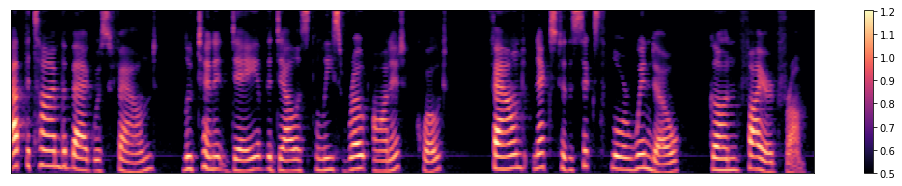

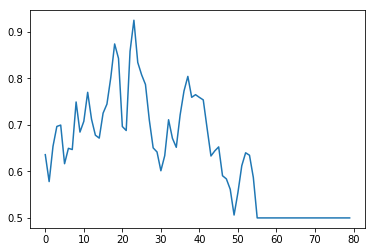

In [15]:
characters = ' abcdefghijklmnopqrstuvwxyz.,!?'

def chars2tokens(chars):    
    tokens = []
    for char in chars:
        try:
            token = characters.index(char)
        except:
            continue
        tokens.append(token)
        
    return tokens

def get_data():
    index = np.random.randint(0, len(file_and_text))
    tokens = chars2tokens(file_and_text[index][2].lower())
    tokens = np.array(tokens)
    
    wave_file = WaveDir + '/' + file_and_text[index][0] + '.wav'
    print(wave_file)
    
    wave, _ = librosa.core.load(wave_file)
    wave /= max(abs(wave))
    
    spec = np.abs(librosa.core.stft(wave, n_fft=2048, hop_length=256)).T
    mel_matrix = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=80, fmin=125, fmax=7600)
    mel = spec @ mel_matrix.T
    
    min_dB = -80
    max_dB = 0
    range_dB = max_dB - min_dB
    mel = 20 * np.log10(np.maximum(mel, 1e-2))
    mel = (mel + range_dB) / range_dB
    
    return tokens, mel
    
tokens, mel = get_data()

print(tokens)
plt.figure(figsize=[18, 3])
librosa.display.specshow(mel.T)
plt.colorbar()
plt.show()
    
plt.plot(mel[10])
plt.show()

In [55]:
import torch
import torch.nn as nn
from torch.nn import functional as F

MelDim = 80

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(len(characters), 512)
        convs = []
        for _ in range(3):
            conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=5, padding=2),
                                nn.BatchNorm1d(512),
                                nn.ReLU(),
                                nn.Dropout(0.5))
        self.convs = nn.ModuleList(convs)
        
        self.gru = nn.GRU(512, 512, 1, bidirectional=True)
    
    def forward(self, tokens):
        # tokens : [Batch, TokenLength]
        # outputs : [Batch, TokenLength, Dim]

        '''
        Embedding
        '''
        # [Batch, TokenLength, Dim]
        x = self.embedding(tokens)
        
        '''
        Conv1D
        '''
        # [Batch, Dim, TokenLength]
        x = x.transpose(1, 2)
        for conv in self.convs:
            x = conv(x)
        
        # [TokenLength, Batch, Dim]
        x = x.permute(2, 0, 1)
        outputs, _ =self.gru(x)
        
        # [Batch, TokenLength, Dim]
        outputs = outputs.transpose(1, 0)
        
        return outputs
        
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.v = nn.Linear(128, 1)
        self.location_layer = nn.Conv1d(1, 128, kernel_size=31, padding=15)
        
    def get_alignment_energies(self, attention_hidden, encoder_outputs, prev_attention_weights):
        # attention_hidden : [Batch, Dim]
        # encoder_outputs : [Batch, TokenLength, Dim]
        # prev_attention_weights : [Batch, TokenLength]
        
        # [Batch, 1, Dim]
        attention_hidden = attention_hidden.unsqueeze(1)
        
        # [Batch, Dim, TokenLength]
        prev_attention_weights = self.location_layer(prev_attention_weights.unsqueeze(1))
        # [Batch, TokenLength, Dim]
        prev_attention_weights = prev_attention_weights.transpose(1, 2)
                
        # [Batch, TokenLength, 1]
        energies = self.v(torch.tanh(attention_hidden + encoder_outputs + prev_attention_weights))
        # [Batch, TokenLength]
        energies = energies.squeeze(2)
        
        return energies
        
    def forward(self, attention_hidden, encoder_outputs, prev_attention_weights):
        # attention_hidden : [Batch, Dim]
        # encoder_outputs : [Batch, TokenLength, Dim]
        # prev_attention_weights : [Batch, TokenLength]
        
        # [Batch, TokenLength]
        alignments = self.get_alignment_energies(attention_hidden, encoder_outputs, prev_attention_weights)
        
        # [Batch, TokenLength]
        attention_weights = F.softmax(alignments, dim=1)
        
        # [Batch, 1, Dim]
        attention_context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # [Batch, Dim]
        attention_context = attention_context.squeeze(1)
        
        return attention_context, attention_weights
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.prenet = nn.Sequential(nn.Linear(MelDim, 256), 
                                   nn.ReLU(),
                                   nn.Dropout(),
                                   nn.Linear(256, 256), 
                                   nn.ReLU(),
                                   nn.Dropout())
        self.attention_rnn = nn.GRUCell(512, 256)
        self.attention_layer = Attention()
        self.decoder_rnn = nn.GRUCell(512, 256)
        self.out_projection = nn.Linear(512, MelDim)
        
    def initialize_decoder_states(self, tensor, batch_size, token_length): 
        
        self.attention_hidden = tensor.new_zeros(batch_size, 256)
        self.decoder_hidden = tensor.new_zeros(batch_size, 256)
        
        self.attention_context = tensor.new_zeros(batch_size, 256)
        self.attention_weights = tensor.new_zeros(batch_size, token_length)
        
    def forward(self, encoder_outputs, mels):
        # encoder_outputs : [Batch, TokenLength, Dim]
        # mels : [Batch, MelLength, MelDim]
        
        batch_size, token_length, _ = encoder_outputs.size()
        
        # mels 맨 앞에 zero padding
        mels_prev = F.pad(mels[:, 1:], (0, 0, 1, 0))
        # [MelLength, Batch, MelDim]
        mels_prev = mels_prev.transpose(1, 0)
        
        # decoding loop에 필요한 state들을 zero로 초기화
        self.initialize_decoder_states(encoder_outputs, batch_size, token_length)
        
        outputs = []
        for mel in mels_prev:
            # mel : [Batch, MelDim]
            
            '''
            Prenet
            '''
            # [Batch, Dim]
            x = self.prenet(mel)
            
            '''
            Attention RNN
            '''
            # [Batch, Dim]
            cell_input = torch.cat([x, self.attention_context], dim=1)
            # [Batch, Dim]
            self.attention_hidden = self.attention_rnn(cell_input, self.attention_hidden)
            self.attention_hidden = F.dropout(self.attention_hidden, p=0.5, training=True)
            
            '''
            Attention
            '''
            # [Batch, Dim], [Batch, TokenLength]
            self.attention_context, self.attention_weights = \
                self.attention_layer(self.attention_hidden, encoder_outputs, self.attention_weights)
            
            '''
            Decoder RNN
            '''
            # [Batch, Dim]
            decoder_input = torch.cat([self.attention_hidden, self.attention_context], dim=1)
            # [Batch, Dim]
            self.decoder_hidden = self.decoder_rnn(decoder_input, self.decoder_hidden)
            self.decoder_hidden = F.dropout(self.decoder_hidden, p=0.5, training=True)
            
            # [Batch, Dim * 2]
            output = torch.cat([self.decoder_hidden, self.attention_context], dim=1)
            # [Batch, MelDIm]
            output = self.out_projection(output)
            
            outputs.append(output)
        
        # [Batch, MelLength, MelDim]
        outputs = torch.stack(outputs, dim=1)
        
        return outputs
        

class Tacotron(nn.Module):
    def __init__(self):
        super(Tacotron, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, inputs, mels):
        # inputs : [Batch, TokenLength]
        # mels : [Batch, MelLength, MelDim]
        encoder_outputs = self.encoder(inputs)
        decoder_outputs = self.decoder(encoder_outputs, mels)
        
        return decoder_outputs
        

In [58]:
tokens = torch.randint(0, len(characters), [1, 20])
mels = torch.randn(1, 100, MelDim)
tacotron = Tacotron()
tacotron_outputs = tacotron(tokens, mels)
print(tacotron_outputs.size())

torch.Size([1, 100, 80])


In [43]:
encoder_outputs = torch.randn(1, 20, 256)
mels = torch.randn(1, 100, MelDim)

decoder = Decoder()
outputs = decoder(encoder_outputs, mels)
print(outputs.size())


torch.Size([1, 100, 80])


In [ ]:
while(True)